# WZGW Projekt 1
Nr indeksu: 311512

In [444]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import folium
from shapely.geometry import Point
# X, Y, Z - współrzędne geodezyjne, nie matematyczne...
%matplotlib inline
plt.style.use('seaborn-poster')
# sns.set_theme()

# Funkcje do zamiany współrzędnych

In [445]:
def delta_vector(A, B):
    """zwraca wektor delt między dwoma punktami A do B. A,B: np.array()"""
    if len(A) != len(B):
        print("A and B dimensions are not the same (they should be)")
        return
    delts = []
    for i in range(len(A)):
        delts.append(B[i]-A[i])
    return np.array(delts)

In [446]:
def geo2xyz(fi, lam, h, a=6378137, e2=0.00669437999013):
    # dorobic domusllne a i e2 dla elipsoidy GRS80
    """funkcja zamienia współrzędne geodezyjne na kartezjańskie fi, lam podajemy w radianachpython """
    fi = np.deg2rad(fi)
    lam = np.deg2rad(lam)
    N = a / np.sqrt(1 - e2 * np.sin(fi) ** 2)
    x = (N + h) * np.cos(fi) * np.cos(lam)
    y = (N + h) * np.cos(fi) * np.sin(lam)
    z = (N * (1 - e2) + h) * np.sin(fi)
    return np.array([x, y, z])

In [447]:
def xyz2neu(fi, lam, A, B):
    # def xyz2neu(A:punktodniesienia/startowy, B:koniecwektora):
    """funkcja zamienia wsp kartezjańskie na topocentryczne neu
    A, B reprezentują punkty, A to początek, B to koniec wektora
    A, B są typu np.array i mają 3 współrzędne: x, y, z
    fi, lam to współrzędne punktu A potrzebne do macierzy obrotu"""
    # x, y, z -> north, east, up
    # fi, lambda, lotniska
    # wektor AB (od lotniska do samolotu)
    fi = np.deg2rad(fi)
    lam = np.deg2rad(lam)
    rotation_matrix = np.array([
        [-1*np.sin(fi)*np.cos(lam), -1*np.sin(lam), np.cos(fi)*np.cos(lam)],
        [-1*np.sin(fi)*np.sin(lam), np.cos(lam), np.cos(fi)*np.sin(lam)],
        [np.cos(fi), 0, np.sin(fi)]
    ])
    vector = delta_vector(A, B)
    return rotation_matrix.transpose() @ vector

# Pozyskanie i obróbka danych

In [448]:
orig_df = pd.read_csv('radar.csv', sep=';')

In [449]:
# orig_df.info()

In [450]:
# orig_df.describe(include='all')

In [451]:
main_df = orig_df
pd.set_option('display.max_colwidth', None)
main_df['xyz'] = pd.Series(map(geo2xyz, main_df['Latitude'], main_df['Longitude'], main_df['Meters']))

In [452]:
main_df['neu'] = pd.Series(map(xyz2neu, 
                               list(itertools.repeat(52.1786, 917)), 
                               list(itertools.repeat(20.9559, 917)), 
                               list(itertools.repeat([3660166.5031345594, 1401774.9245151733, 5015181.999035442], 
                                                     917)), 
                               main_df['xyz']
                              )
                          )

In [453]:
main_df['n'] = pd.Series(map(lambda x: x[0], main_df['neu']))

In [454]:
main_df['e'] = pd.Series(map(lambda x: x[1], main_df['neu']))

In [455]:
main_df['u'] = pd.Series(map(lambda x: x[2], main_df['neu']))

In [456]:
main_df['tanA'] = main_df['e']/main_df['n']

In [457]:
main_df['s'] = np.sqrt(main_df['n']**2 + main_df['e']**2 + main_df['u']**2)

In [458]:
main_df['cosz'] = main_df['u']/main_df['s']

In [459]:
main_df

,Latitude,Longitude,Meters,kmh,xyz,neu,n,e,u,tanA,s,cosz
0,37.4806,126.4373,115,327,"[-3009986.9279177887, 4077087.335196061, 3859925.648851618]","[3456194.312054833, 4883932.042864793, -4145454.040411133]",3.456194e+06,4.883932e+06,-4.145454e+06,1.413095,7.278933e+06,-0.569514
1,37.4926,126.4277,298,333,"[-3008908.6770793367, 4077056.266483708, 3861093.862974308]","[3456124.0398608404, 4883517.393530443, -4143920.5991438404]",3.456124e+06,4.883517e+06,-4.143921e+06,1.413004,7.277748e+06,-0.569396
2,37.5041,126.4187,413,352,"[-3007861.0886884076, 4076977.0155891557, 3862176.543878538]","[3456037.5497620427, 4883068.715379161, -4142482.8483097763]",3.456038e+06,4.883069e+06,-4.142483e+06,1.412910,7.276587e+06,-0.569289
3,37.5174,126.4078,474,391,"[-3006580.627028365, 4076864.661696517, 3863384.693334532]","[3455865.564098778, 4882505.836839043, -4140819.8933348134]",3.455866e+06,4.882506e+06,-4.140820e+06,1.412817,7.275181e+06,-0.569171
4,37.5421,126.3868,603,447,"[-3004156.090917171, 4076704.2115607024, 3865637.4877571473]","[3455503.787353974, 4881488.865935644, -4137687.1485192087]",3.455504e+06,4.881489e+06,-4.137687e+06,1.412671,7.272544e+06,-0.568946
...,...,...,...,...,...,...,...,...,...,...,...,...
912,52.2403,20.9018,693,232,"[3656694.4515809016, 1396487.460066755, 5019768.603065541]","[6867.564306236855, -3695.9535824309232, 475.2330267139282]",6.867564e+03,-3.695954e+03,4.752330e+02,-0.538175,7.813409e+03,0.060823
913,52.2294,20.9113,523,232,"[3657261.3345508967, 1397398.8339414, 5018891.353449281]","[5653.978218917138, -3047.606921202584, 306.76657360920626]",5.653978e+03,-3.047607e+03,3.067666e+02,-0.539020,6.430356e+03,0.047706
914,52.1966,20.9400,358,246,"[3659160.510699166, 1400225.388276155, 5016524.526847928]","[2003.1080726386724, -1087.251220554971, 144.59286333778505]",2.003108e+03,-1.087251e+03,1.445929e+02,-0.542782,2.283739e+03,0.063314
915,52.1872,20.9483,282,253,"[3659685.91079667, 1401034.2542547686, 5015823.264119978]","[956.9986575715795, -519.7958519587401, 68.90704044991122]",9.569987e+02,-5.197959e+02,6.890704e+01,-0.543152,1.091230e+03,0.063146


# Wizualizacja lotu
1. Mapa interaktywna
2. Trasa lotu
3. Nad którymi krajami przeleciał samolot?

## 1. Mapa interaktywna

In [460]:
m = folium.Map(location=[60, 70], tiles="OpenStreetMap", zoom_start=4, )
tilesy = ["OpenStreetMap", "Stamen Terrain", "Stamen Toner", "Stamen Watercolor", "CartoDB positron", "CartoDB dark_matter"]
for tilename in tilesy:
    folium.TileLayer(tilename, control=True).add_to(m)
folium.LayerControl().add_to(m);

In [461]:
def tooltipp(Latitude, Longitude):
    tekst = f"Latitude: {Latitude}" + "\n" + f"Longitude: {Longitude}"
    return tekst

In [462]:
def popupp(Lat, Lon, Meters, kmh, u):
    tekst = f"{Lat=}, {Lon=}, {Meters=}, {kmh=}, {u=}"
    return tekst

In [463]:
main_df.apply(lambda row: folium.Circle(location=[row['Latitude'], row['Longitude']], fill=True, color="#f108f2",\
                                        radius=1500, tooltip=tooltipp(row['Latitude'], row['Longitude']),\
                                        popup=popupp(row['Latitude'], row['Longitude'], row['Meters'], row['kmh'], row['u'])\
                                       ).add_to(m), axis=1
             );

# m.add_child(folium.LatLngPopup())

In [464]:
m

## 2. Trasa lotu

In [465]:
gdf = gpd.GeoDataFrame(main_df, 
                       geometry=[Point(x, y) for x, y in zip(main_df['Longitude'], main_df['Latitude'])], 
                       crs="EPSG:4326")  # ,crs="EPSG:4326"

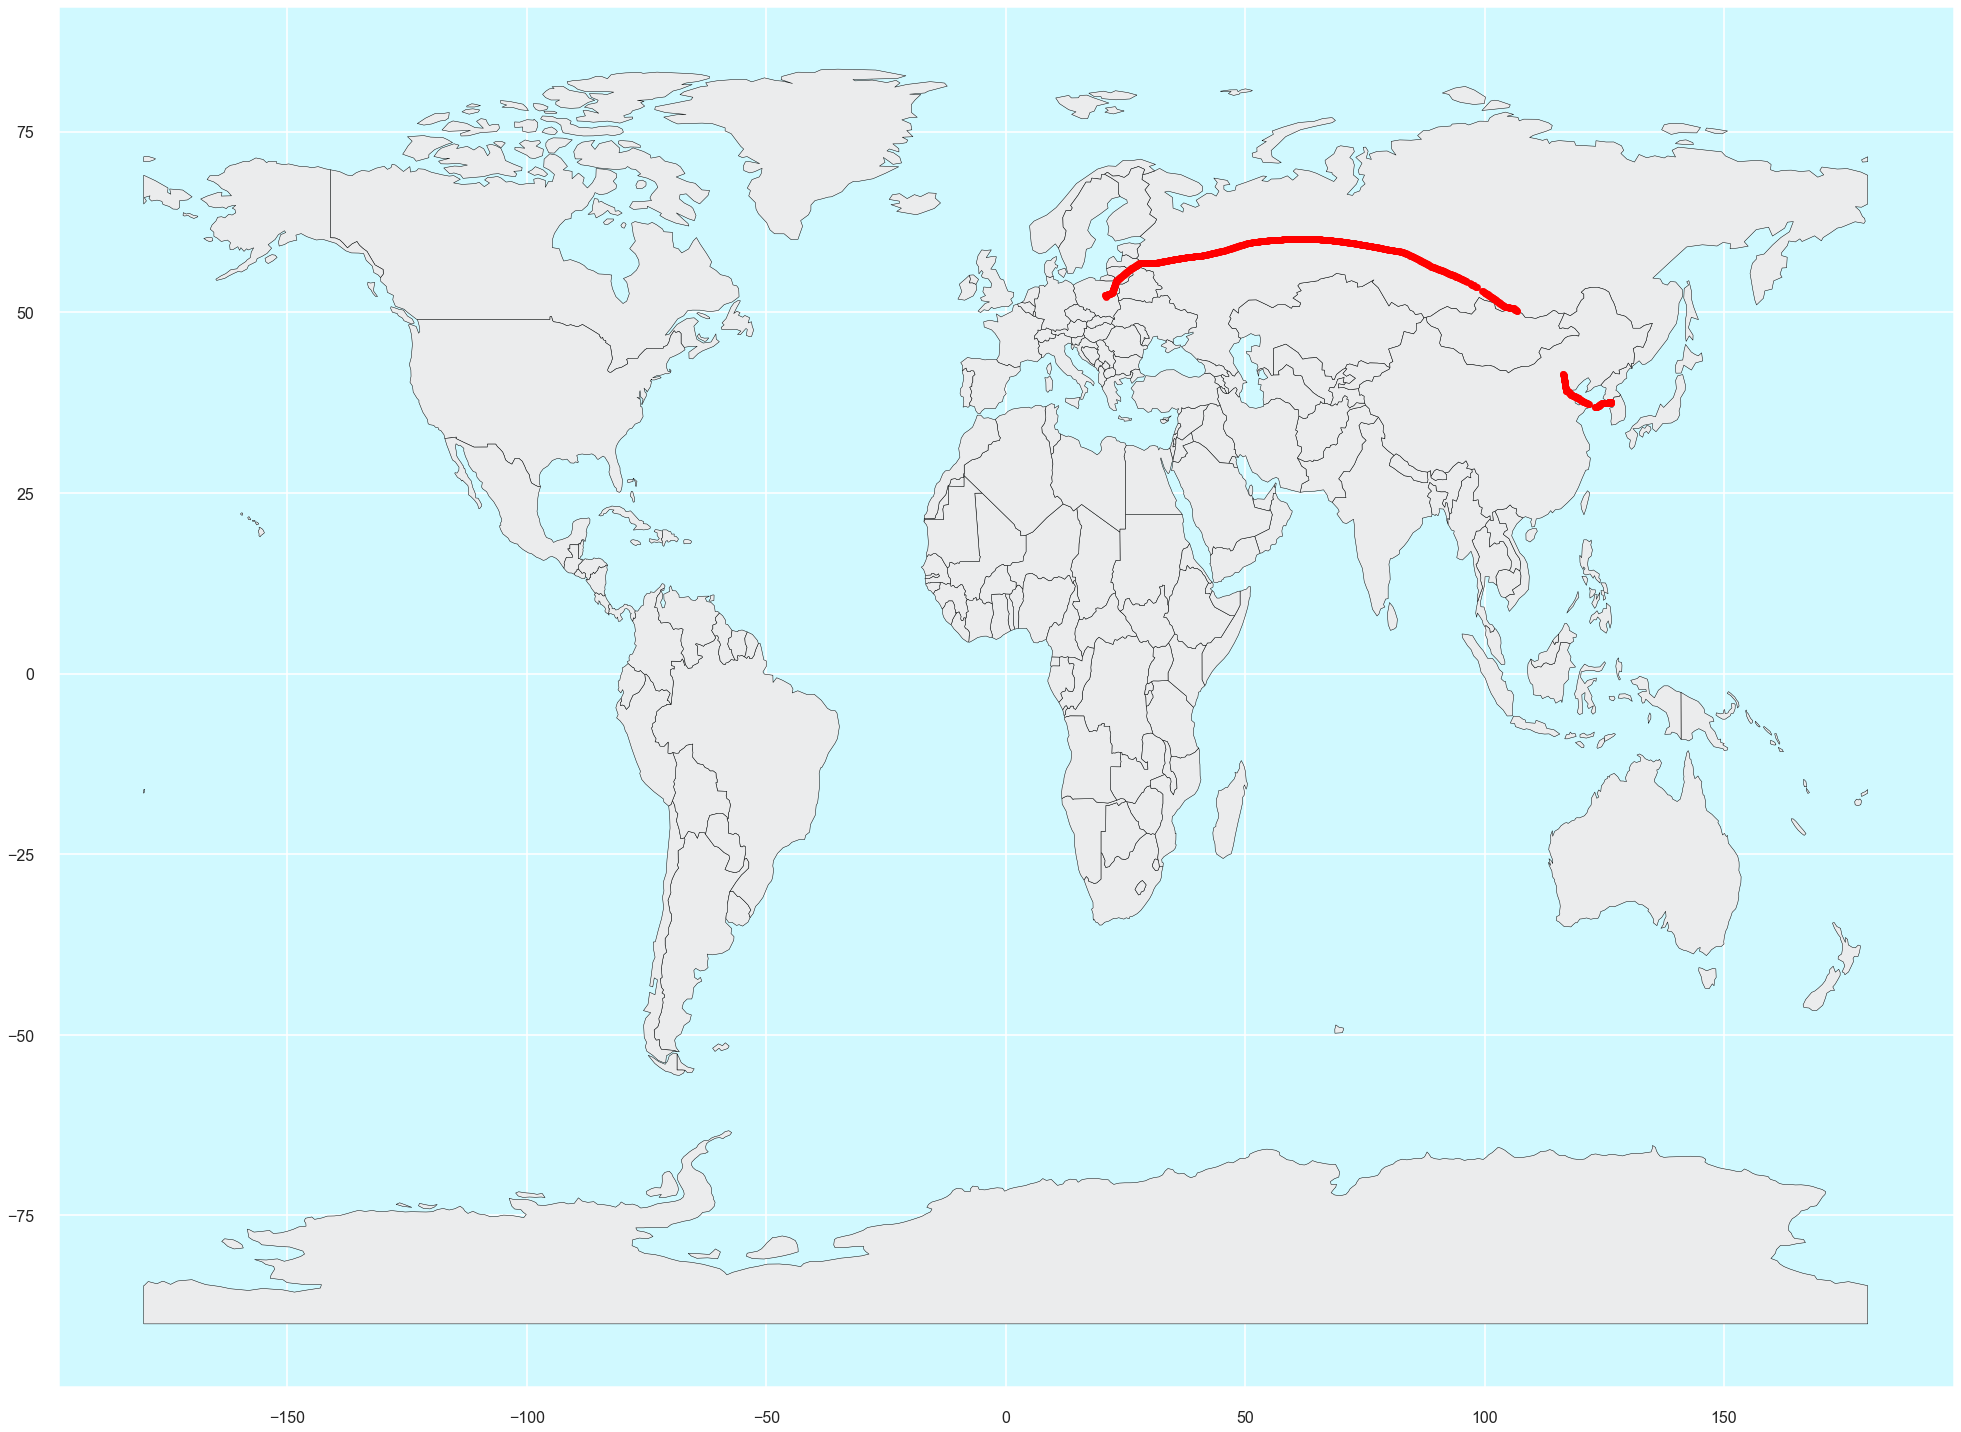

In [466]:
px = 1/plt.rcParams['figure.dpi']  # pixel in inches
fig, ax = plt.subplots(figsize=(2560*px, 1440*px),)  # dpi=200
# ax.set_aspect('equal')
ax.set_facecolor('#d0f9ff')
# ax.set_axis_off();  fig.set_facecolor('#d0f9ff')

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='#ebeced', edgecolor='black')
gdf.plot(ax=ax, marker='o', color='red', markersize=40)

# plt.style.use('default')
# plt.style.use('seaborn-poster')
plt.tight_layout()

plt.savefig('mapka.png')
plt.show()

In [467]:
# gdf
# world

## 3. Nad którymi krajami przeleciał samolot?

In [468]:
multipunkt = gdf['geometry'].unary_union
filt = world['geometry'].intersects(multipunkt)
world['flewover'] = filt
world[filt].name

18          Russia
96     South Korea
97        Mongolia
113         Poland
118      Lithuania
119         Latvia
139          China
Name: name, dtype: object

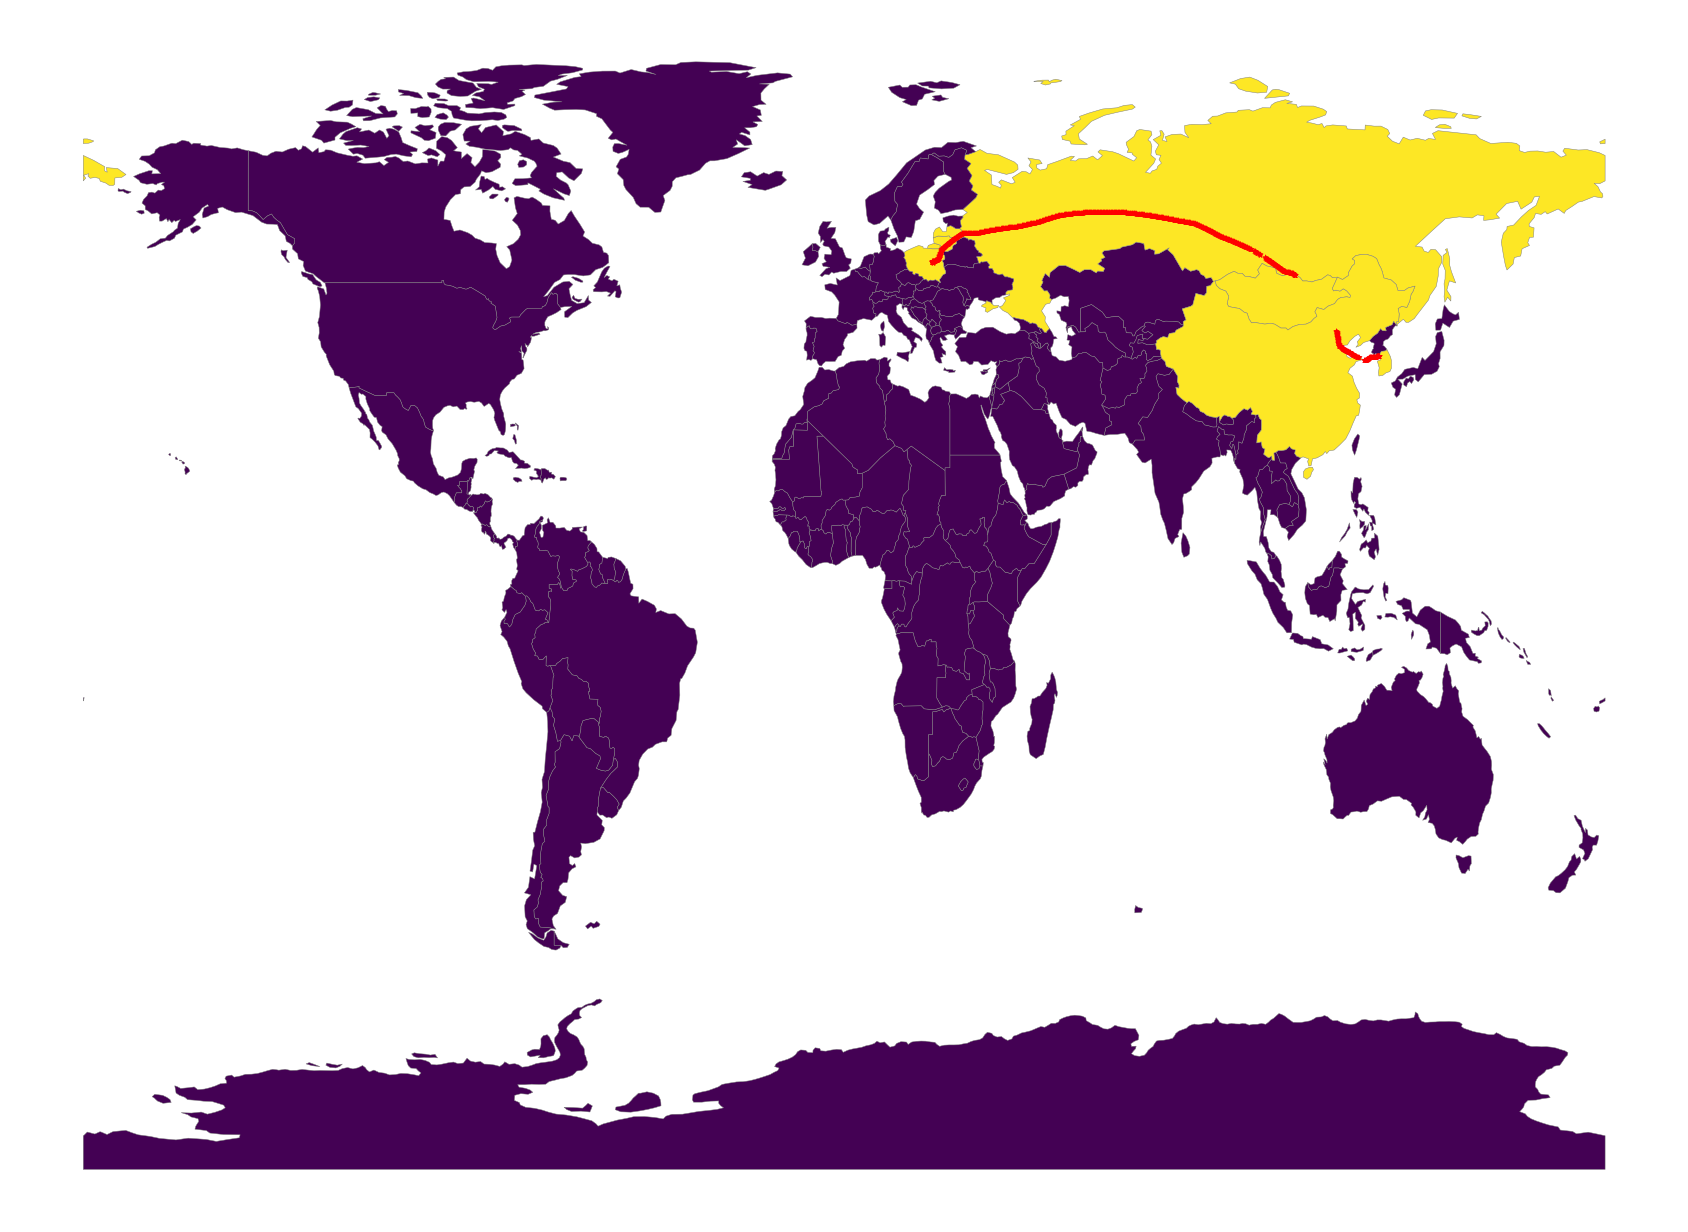

In [469]:
fig, ax = plt.subplots(figsize=(30,30))  # figsize=(,)
ax.set_aspect('equal')
# ax.set_facecolor('#d0f9ff')
ax.set_axis_off();  fig.set_facecolor('white')  #d0f9ff

world.plot(ax=ax, edgecolor='grey', column='flewover', legend=False, cmap=plt.cm.get_cmap('viridis', 2))  # 'Blues'
gdf.plot(ax=ax, marker='*', color='red', markersize=30)

plt.show()

# !!! dorobić mapke 3d neu + draggable globus plotly !!!

# Wykresy

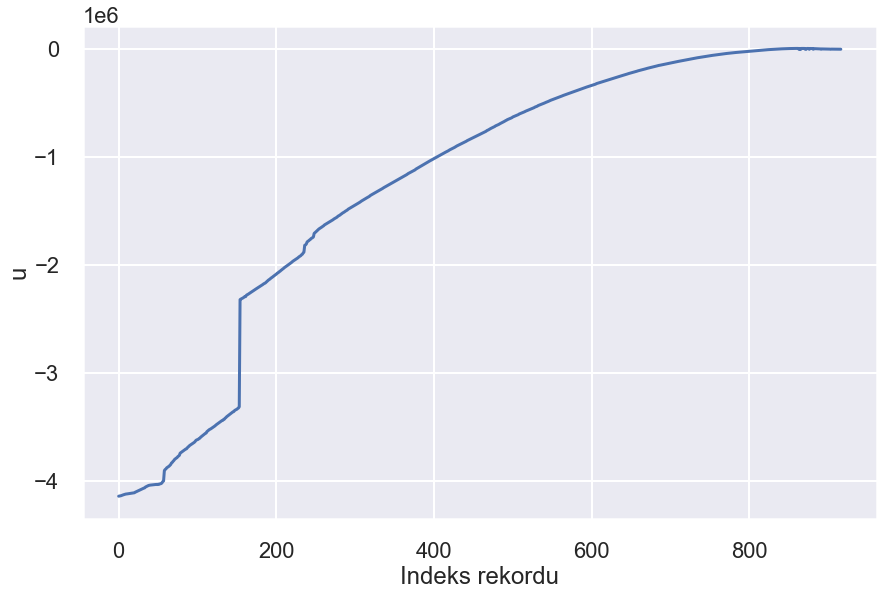

In [470]:
sns.set_theme(context='poster', style='darkgrid')

plt.plot(gdf.index, gdf['u'],)  # gdf.index[::-1]

plt.xlabel('Indeks rekordu')
plt.ylabel('u')

plt.tight_layout()
plt.show()

In [471]:
gdf[gdf['u'] > -100]['u']  # .describe()

832     -64.077138
833     369.539489
834     819.830178
835    1237.793643
836    1648.625857
          ...     
912     475.233027
913     306.766574
914     144.592863
915      68.907040
916       0.000000
Name: u, Length: 78, dtype: float64

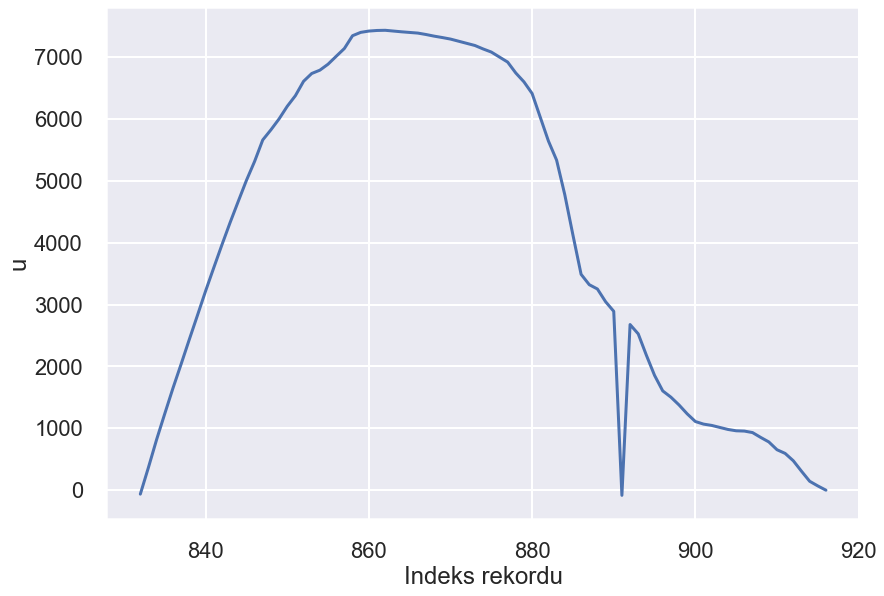

In [472]:
sns.set_theme(context='poster', style='darkgrid')

plt.plot(gdf[gdf['u'] > -100]['u'].index, gdf[gdf['u'] > -100]['u'])

plt.xlabel('Indeks rekordu')
plt.ylabel('u')

plt.tight_layout()
plt.show()

##### Coś tu nie pasuje w danych...

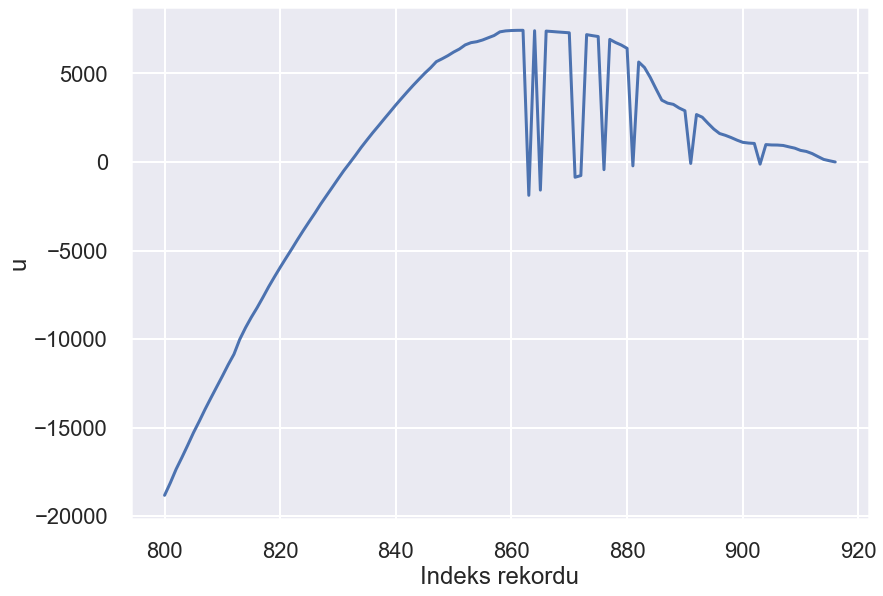

In [473]:
sns.set_theme(context='poster', style='darkgrid')

plt.plot(gdf.index[800:], gdf.loc[800:]['u'])

plt.xlabel('Indeks rekordu')
plt.ylabel('u')

plt.tight_layout()
plt.show()

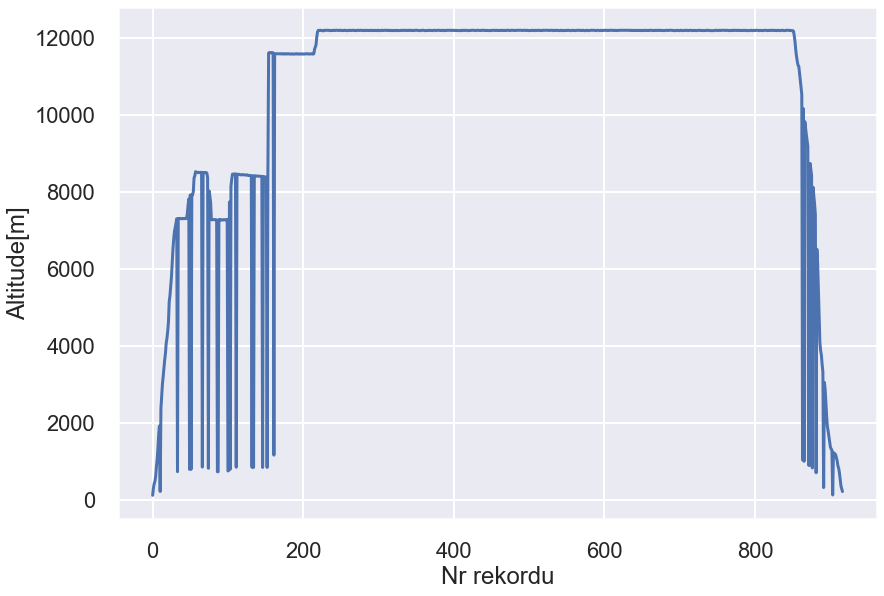

In [474]:
sns.set_theme(context='poster', style='darkgrid')

plt.plot(gdf.index, gdf['Meters'])

plt.xlabel('Nr rekordu')
plt.ylabel('Altitude[m]')

plt.tight_layout()
plt.show()

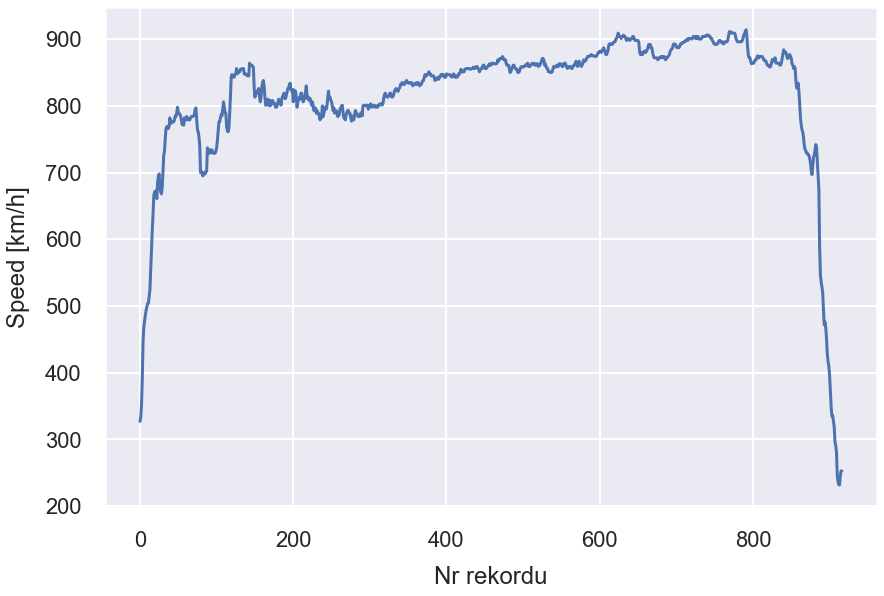

In [475]:
sns.set_theme(context='poster', style='darkgrid')

plt.plot(gdf.index, gdf['kmh'])

plt.xlabel('Nr rekordu', labelpad=15)
plt.ylabel('Speed [km/h]', labelpad=15)

plt.tight_layout()
plt.show()